In [ ]:
# Code Python : CalculateField 2 - Calculer la densité de population
import arcpy

# Définir le chemin vers la couche des communes
commune_layer = "\\Layers\\CAD_COMMUNE.shp"

# Ajouter un champ pour la densité de la population avec un nom de champ plus court
arcpy.AddField_management(commune_layer, "PopDens", "DOUBLE")

# Calculer la densité de population pour chaque commune
with arcpy.da.UpdateCursor(commune_layer, ["Total_Pop", "st_area_sh", "PopDens"]) as cursor:
    for row in cursor:
        population = row[0]  # Population totale
        area_m2 = row[1]     # Surface en mètres carrés
        if area_m2 > 0:  # Pour éviter la division par zéro
            area_km2 = area_m2 / 1000000  # Convertir en kilomètres carrés
            density = population / area_km2  # Calculer la densité
            row[2] = density  # Mettre à jour le champ de densité
        else:
            row[2] = 0  # Assigner 0 si la surface est 0 pour éviter des erreurs
        cursor.updateRow(row)

print("La densité de population a été calculée pour chaque commune.")


In [11]:
# Code Python : CalculateField 3 - Calculer le nombre d'arrêts par commune
import arcpy

# Définir les chemins vers les couches
commune_layer = "\\Layers\\CAD_COMMUNE.shp"
arrets_layer = "\\Layers\\TPG_ARRETS.shp"

# Ajouter un champ pour le nombre d'arrêts
arcpy.AddField_management(commune_layer, "NbArrets", "LONG")

# Créer une couche temporaire pour les requêtes spatiales
arcpy.MakeFeatureLayer_management(arrets_layer, "arrets_layer_lyr")

# Calculer le nombre d'arrêts pour chaque commune
with arcpy.da.UpdateCursor(commune_layer, ["SHAPE@", "NbArrets"]) as cursor:
    for row in cursor:
        # Sélectionner les arrêts qui intersectent la commune
        arcpy.SelectLayerByLocation_management("arrets_layer_lyr", "INTERSECT", row[0])
        
        # Compter le nombre d'arrêts sélectionnés
        count = arcpy.GetCount_management("arrets_layer_lyr")
        
        # Mettre à jour le champ avec le nombre d'arrêts
        row[1] = int(count.getOutput(0))
        cursor.updateRow(row)

print("Le nombre d'arrêts par commune a été calculé et enregistré.")


Le nombre d'arrêts par commune a été calculé et enregistré.


In [12]:
# Code Python : CalculateField 4 - Calculer le total de la population des adresses non desservies par commune
import arcpy

# Définir les chemins vers les couches
commune_layer = "\\Layers\\CAD_COMMUNE.shp"
non_served_addresses_layer = "\\Layers\\adresses_non_desservies.shp"

# Ajouter un champ pour la population totale non desservie
arcpy.AddField_management(commune_layer, "PopNonServ", "LONG")

# Créer une couche temporaire pour les adresses non desservies
arcpy.MakeFeatureLayer_management(non_served_addresses_layer, "non_served_addresses_lyr")

# Calculer la population totale non desservie pour chaque commune
with arcpy.da.UpdateCursor(commune_layer, ["SHAPE@", "PopNonServ"]) as cursor:
    for row in cursor:
        # Sélectionner les adresses non desservies qui intersectent la commune
        arcpy.SelectLayerByLocation_management("non_served_addresses_lyr", "INTERSECT", row[0])

        # Calculer la somme de la population pour les adresses sélectionnées
        sum_population = 0
        with arcpy.da.SearchCursor("non_served_addresses_lyr", ["population"]) as address_cursor:
            for address in address_cursor:
                sum_population += address[0]

        # Mettre à jour le champ avec la somme de la population non desservie
        row[1] = sum_population
        cursor.updateRow(row)

print("Le total de la population des adresses non desservies par commune a été calculé et enregistré.")


Le total de la population des adresses non desservies par commune a été calculé et enregistré.


In [5]:
# Code Python : Near - Calculer la distance moyenne à l'arrêt le plus proche
import arcpy
# Définir les chemins vers les couches
addresses_layer = "\\Layers\\OCS_POPULATION_ADRESSE.shp"
arrets_layer = "\\Layers\\TPG_ARRETS.shp"
# Calculer la distance de chaque adresse à l'arrêt le plus proche
arcpy.analysis.Near(addresses_layer, arrets_layer, location="NO_LOCATION", angle="NO_ANGLE", method="PLANAR")
# Calculer la moyenne de ces distances
distance_sum = 0
count = 0
with arcpy.da.SearchCursor(addresses_layer, ["NEAR_DIST"]) as cursor:
    for row in cursor:
        distance_sum += row[0]
        count += 1
average_distance = distance_sum / count if count > 0 else 0
print("La distance moyenne à l'arrêt le plus proche est : ", int(average_distance), " mètres")


La distance moyenne à l'arrêt le plus proche est :  166  mètres


In [4]:
# Code Python : Export Data
import arcpy
import pandas as pd
# Définir le chemin vers la couche des communes
commune_layer = "\\Layers\\CAD_COMMUNE.shp"
# Extraire les données nécessaires en convertissant st_area_sh en entier directement
fields = ["commune", "st_area_sh", "Total_Pop", "PopDens", "NbArrets", "PopNonServ"]
data = [(row[0], int(row[1]), row[2], row[3], row[4], row[5]) for row in arcpy.da.SearchCursor(commune_layer, fields)]
# Charger les données dans un DataFrame Pandas
df = pd.DataFrame(data, columns=fields)
print(df.head())  # Afficher les premières lignes pour vérifier
# Sauvegarder le DataFrame en fichier Excel
df.to_excel('communes_data.xlsx', index=False)
# Sauvegarder le DataFrame en fichier CSV
df.to_csv('communes_data.csv', index=False)

         commune  st_area_sh  Total_Pop      PopDens  NbArrets  PopNonServ
0        Meinier     6953480       2083   299.562192        24         144
1          Avusy     5172039       1412   273.006439        20         142
2  Perly-Certoux     2536601       3185  1255.616849        16         147
3       Laconnex     3831199        676   176.446063         7           6
4    Vandoeuvres     4419792       2971   672.203545        28         701


Top 5 Communes (Population par arrêt):
      commune  PopPerArret
32     Jussy    30.102564
9   Presinge    49.666667
5    Choulex    60.000000
43  Dardagny    69.222222
1      Avusy    70.600000
Pire 5 Communes (Population par arrêt):
     commune  PopPerArret
25     Onex   608.838710
38   Genève   553.287634
44  Carouge   537.761905
39    Lancy   452.712500
31  Céligny   438.000000


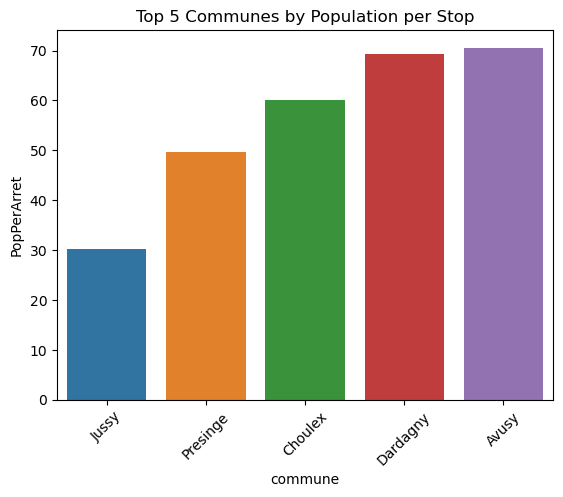

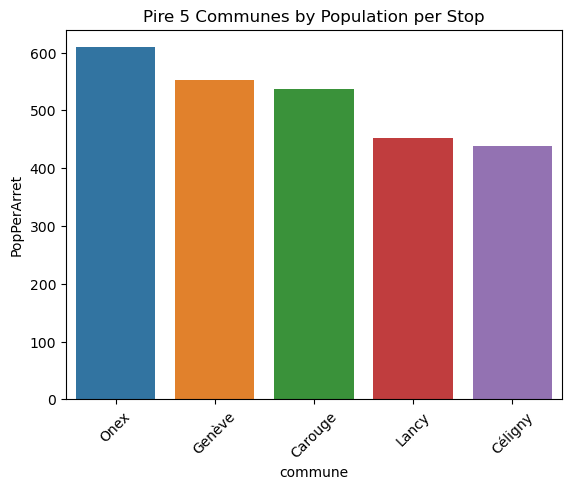

In [5]:
# Code Python : Visualisation 1 - Analyse des Communes par Population par Arrêt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Trier les données par ratio de population par arrêt et sélectionner le top 5 et pire 5
df['PopPerArret'] = df['Total_Pop'] / df['NbArrets']
worst_5_pop_arrets = df.sort_values(by='PopPerArret', ascending=False).head(5)
top_5_pop_arrets = df.sort_values(by='PopPerArret').head(5)

print("Top 5 Communes (Population par arrêt):\n", top_5_pop_arrets[['commune', 'PopPerArret']])
print("Pire 5 Communes (Population par arrêt):\n", worst_5_pop_arrets[['commune', 'PopPerArret']])

# Graphique de la population par arrêt pour Top 5
sns.barplot(x='commune', y='PopPerArret', data=top_5_pop_arrets)
plt.title('Top 5 Communes by Population per Stop')
plt.xticks(rotation=45)
plt.show()

# Graphique de la population par arrêt pour pire 5
sns.barplot(x='commune', y='PopPerArret', data=worst_5_pop_arrets)
plt.title('Pire 5 Communes by Population per Stop')
plt.xticks(rotation=45)
plt.show()

Top 5 Communes (Densité par arrêt):
      commune  DensPerArret
32     Jussy      2.652146
20   Satigny      4.158203
43  Dardagny      8.050706
9   Presinge     10.550491
12   Anières     10.927105
Pire 5 Communes (Densité par arrêt):
         commune  DensPerArret
13  Chêne-Bourg    295.477185
25         Onex    216.365778
44      Carouge    199.418923
24    Confignon    117.629931
39        Lancy     94.822907


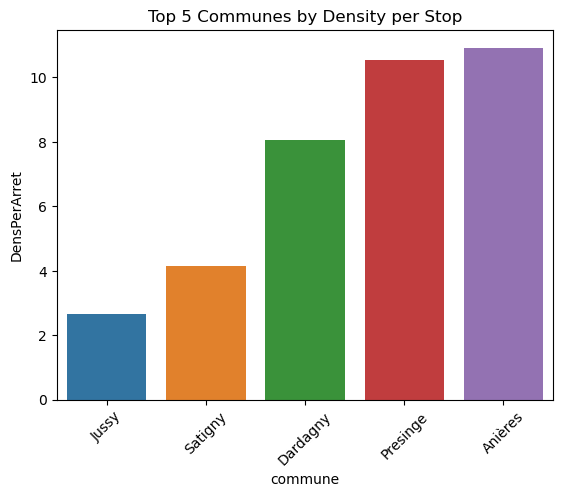

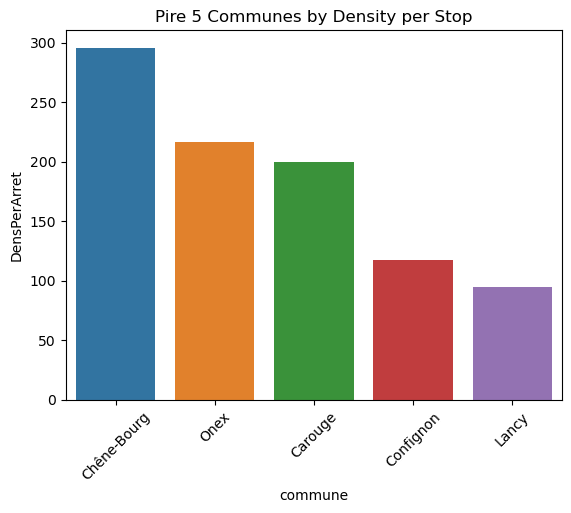

In [9]:
# Code Python : Visualisation 2 - Analyse des Communes par Densité de Population par Arrêt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Trier les données par ratio de la  population par arrêt et sélectionner le top 5 et pire 5
df['DensPerArret'] = df['PopDens'] / df['NbArrets']
worst_5_dens_arrets = df.sort_values(by='DensPerArret', ascending=False).head(5)
top_5_dens_arrets = df.sort_values(by='DensPerArret').head(5)

print("Top 5 Communes (Densité par arrêt):\n", top_5_dens_arrets[['commune', 'DensPerArret']])
print("Pire 5 Communes (Densité par arrêt):\n", worst_5_dens_arrets[['commune', 'DensPerArret']])

# Graphique de la population par arrêt pour Top 5
sns.barplot(x='commune', y='DensPerArret', data=top_5_dens_arrets)
plt.title('Top 5 Communes by Density per Stop')
plt.xticks(rotation=45)
plt.show()

# Graphique de la population par arrêt pour pire 5
sns.barplot(x='commune', y='DensPerArret', data=worst_5_dens_arrets)
plt.title('Pire 5 Communes by Density per Stop')
plt.xticks(rotation=45)
plt.show()


Top 10 Communes (Population par PopNonServ):
            commune  PopPerNonDes
14  Grand-Saconnex          0.25
13     Chêne-Bourg          0.36
38          Genève          0.49
22   Aire-la-Ville          0.69
44         Carouge          0.78
3         Laconnex          0.89
12         Anières          1.16
36        Puplinge          1.64
39           Lancy          2.16
37         Vernier          2.31
Pire 10 Communes (Population par PopNonServ):
                commune  PopPerNonDes
31             Céligny         46.69
9             Presinge         26.31
4          Vandoeuvres         23.59
19              Avully         23.13
5              Choulex         22.54
16     Pregny-Chambésy         18.69
6   Collonge-Bellerive         18.26
28             Troinex         14.32
32               Jussy         14.05
11            Bellevue         13.89


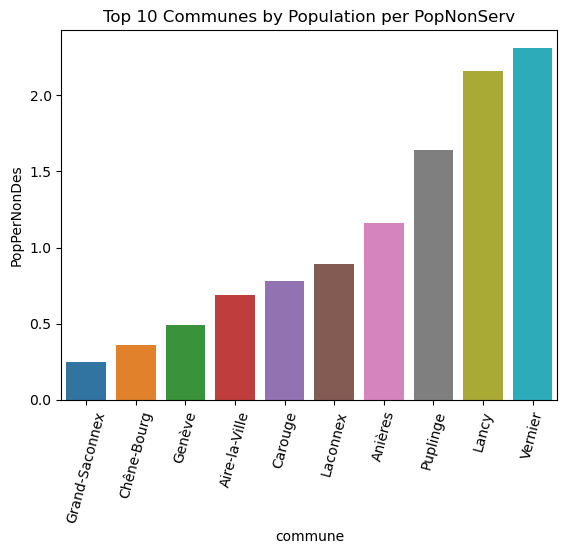

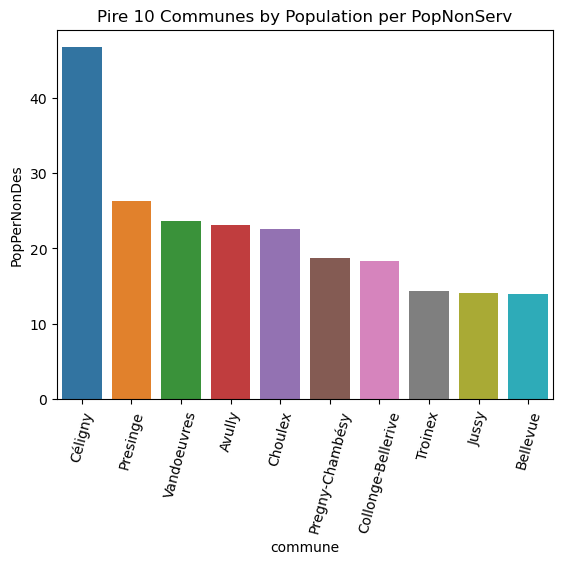

In [11]:
# Code Python : Visualisation 3 - Analyse des Communes par Population par Population Non deservi
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Trier les données par ratio de population par arrêt et sélectionner le top 5 et pire 5
df['PopPerNonDes'] = ((df['PopNonServ'] / df['Total_Pop']) * 100).round(2)
worst_10_pop_NonDes = df.sort_values(by='PopPerNonDes', ascending=False).head(10)
top_10_pop_NonDes = df.sort_values(by='PopPerNonDes').head(10)

print("Top 10 Communes (Population par PopNonServ):\n", top_10_pop_NonDes[['commune', 'PopPerNonDes']])
print("Pire 10 Communes (Population par PopNonServ):\n", worst_10_pop_NonDes[['commune', 'PopPerNonDes']])

# Graphique de la population par arrêt pour Top 5
sns.barplot(x='commune', y='PopPerNonDes', data=top_10_pop_NonDes)
plt.title('Top 10 Communes by Population per PopNonServ')
plt.xticks(rotation=75)
plt.show()

# Graphique de la population par arrêt pour pire 5
sns.barplot(x='commune', y='PopPerNonDes', data=worst_10_pop_NonDes)
plt.title('Pire 10 Communes by Population per PopNonServ')
plt.xticks(rotation=75)
plt.show()